# Optical tweezer forces (modeled as Gaussian beam of known wavelength)

In [34]:
from matplotlib import pyplot as  plt
import numpy as np
import math
from scipy import constants as sp
from inspect import signature
import sys

#define some quantities. I know global variables are bad, but fuck it
pi = sp.pi
e_0 = sp.epsilon_0 #vacuum permittivity
wavelength = 1064*10**-9 
k = 2*pi/wavelength
u_0 = 1 #??? Highly affects scale
w_0 = 1*10**-3 #beam waist: on the order of mm?
z_R = pi * (w_0**2)/k #Rayleigh range

def trap_force_axial(x, y, z, a, n_p, n_m): #what is dependence on a, at some z?
#calculate the prefactor that depends on properties of the particle and of the medium
    r = np.sqrt(x**2 + y**2) #r = 0 #if central axis
    alpha = (n_p**2 - n_m**2)/(n_p**2 + 2*n_m**2)
    prefactor = (pi * e_0 * n_m**2 * a**3 * alpha)/(1 + (2/3 * k**3 * a**3)**2 * alpha**2)
#calculate the spatial dependence term
    arg = (-2*r**2/w_0**2 * z_R**2) / (z**2 + z_R**2)#argument of the exponential
    spatial = 2*u_0**2 * z_R**2 * z * np.exp(arg) * ((2*r**2/w_0**2 - 1)*z_R**2 - z**2) / (z**2 + z_R**2)**3
    return prefactor*spatial

def trap_force_transverse(a, x, y, n_p, n_m): #x-y forces
    z = 1*10**-10
    r = np.sqrt(x**2 + y**2)
    alpha = (n_p**2 - n_m**2)/(n_p**2 + 2*n_m**2)
    prefactor = (-4*pi * e_0 * n_m**2 * a**3 * alpha)/(1 + (2/3 * k**3 * a**3)**2 * alpha**2)
    arg = (-4*r**2/w_0**2 * z_R**2) / (z**2 + z_R**2)#argument of the exponential
    spatial = u_0**2 * z_R**4 * x / (w_0**2 * (z**2 + z_R**2)) * exp(arg)
    return prefactor * spatial

def scat_force_axial(x, y, z, a, n_p, n_m):
    #the scattering force has a spatial bit (u^2 * grad(phi), and the bit that depends on matter
    r = np.sqrt(x**2 + y**2) #r = 0 #if central axis
    arg = (-2*r**2/w_0**2 * z_R**2) / (z**2 + z_R**2)
    u_squared = u_0**2 * z_R**2/(z_R**2 + z**2) * np.exp(arg)
    grad_phi = k - (1/2* k * r**2 * (z**2 - z_R**2)/(z**2 + z_R**2)**2) - z_R/(z**2 + z_R**2)
    alpha = (n_p**2 - n_m**2)/(n_p**2 + 2*n_m**2)
    prefactor = (4/3 * pi * e_0 * alpha**2 * a**6 * k**3 * n_m**2) / (1 + (4/9 * a**6 * k**6 * alpha**2))
    return prefactor * grad_phi * u_squared

def explore_z(a, n_p, n_m):
    x,y = 1*10**-9, 1*10**-9 
    r = np.sqrt(x**2 + y**2) #r = 0 #if central axis
    z_list = np.arange(-5*10**-9, 5*10**-9, 1*10**-10) 
    f_grad_list = [trap_force_axial(x, y, z, a, n_p, n_m) for z in z_list]
    f_scat_list = [scat_force_axial(x, y, z, a, n_p, n_m) for z in z_list]
    #start plotting
    f = plt.figure(figsize=(10,3))
    #define a big suplot, and turn off ticks
    ax = f.add_subplot(111)
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    #plot data
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.plot(z_list, f_grad_list)
    ax1.set_ylabel('Gradient Force (N)')
    ax2.set_ylabel('Scattering Force (N)')
    ax.set_xlabel('z (m)')
    ax2.plot(z_list, f_scat_list, 'r-')
    
def explore_a(z, n_p, n_m):
    x,y = 1*10**-9, 1*10**-9 
    r = np.sqrt(x**2 + y**2) #r = 0 #if central axis
    a_list = np.arange(0.1*10**-6, 5*10**-6, 1*10**-9) #0.1 micron to 5 microns
    f_grad_list = [trap_force_axial(x, y, z, a, n_p, n_m) for a in a_list]
    f_scat_list = [scat_force_axial(x, y, z, a, n_p, n_m) for a in a_list]
    #start plotting
    f = plt.figure(figsize=(10,3))
    #define a big suplot, and turn off ticks
    ax = f.add_subplot(111)
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    #plot data
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.plot(a_list, f_grad_list)
    ax1.set_ylabel('Gradient Force (N)')
    ax2.set_ylabel('Scattering Force (N)')
    ax.set_xlabel('a (m)')
    ax2.plot(a_list, f_scat_list, 'r-')
    
def explore_n(a, z):
    x,y = 1*10**-9, 1*10**-9 
    r = np.sqrt(x**2 + y**2) #r = 0 #if central axis
    delta_list, f_grad_list, f_scat_list = [], [], []
    np_list = np.arange(1.33, 1.60, 0.01)
    nm_list = np.arange(1.33, 1.60, 0.01)
    for n_p in np_list:
        for n_m in nm_list:
            delta = n_p - n_m
            delta_list.append(delta)
            f_grad_list.append(trap_force_axial(x, y, z, a, n_p, n_m))
            f_scat_list.append(scat_force_axial(x, y, z, a, n_p, n_m))            
    f = plt.figure(figsize=(10,3))
    #define a big suplot, and turn off ticks
    ax = f.add_subplot(111)
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    #plot data
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.plot(delta_list, f_grad_list, 'b.')
    ax1.set_ylabel('Gradient Force (N)')
    ax2.set_ylabel('Scattering Force (N)')
    ax.set_xlabel('$\Delta n$')
    ax2.plot(delta_list, f_scat_list, 'r.')

def generate_pts(center, r, npts):
    pts = [(r*math.cos(2*pi*k/npts) + center[0], r*math.sin(2*pi*k/npts) + center[1]) for k in range(0, npts + 1)]
    return pts

def generate_weight(resolution, xp, yp):
    traps = generate_pts(center = [resolution/2, resolution/2], r = 10, npts = 10) #here is where we change the radius of trap, and 
        #number of optical tweezers in the corral
    distsq = 0
    for trap in traps:
        xt = trap[0]
        yt = trap[1]
        distsq += (xp - xt)**2 + (yp - yt)**2
    return distsq

def ring_corral():
    resolution = 100
    weights = np.zeros([resolution, resolution])
    xmax, ymax = resolution/2, resolution/2
    counter = 0
    for row in range(len(weights)):
        for col in range(len(weights)):
            distsq = generate_weight(resolution, row, col)
            weights[row,col] = (1/distsq) #force normally goes as 1/r^2
            counter+=1
    maxval = np.max(weights)
    weights *= 1/maxval
    traps = generate_pts([resolution/2,resolution/2], 10, 10)
    for pt in traps:
        weights[int(pt[0]),int(pt[1])] = 10
    #plotting
    plt.figure()
    plt.imshow(weights, cmap = 'gray', interpolation = 'nearest', extent=[-xmax,xmax,-ymax,ymax])
    plt.colorbar()

def axial_force_landscape(a, z, n_p, n_m):
    #generate an array in x-y with the axial force at each position
    resolution = 100
    plane = np.zeros([resolution, resolution])
    traps = generate_pts(center = [resolution/2, resolution/2], r = 10, npts = 10) #change number of pts and radius here
    print(traps)
    for x in range(len(plane)):
        for y in range(len(plane)):
            force_traps = [scat_force_axial(t[0], t[1], z, a, n_p, n_m) + trap_force_axial(t[0], t[1], z, a, n_p, n_m) for t in traps]
            force = np.sum(force_traps)
            print(force)
    return 
    
#next steps: 
# - superpose forces
# - generate array, popular grid in circular fashion with radius R, this becomes force field, calculate force at any point in the array

#### Force dependence on $z$ ($1\,\mu m$ silica in DMSO):

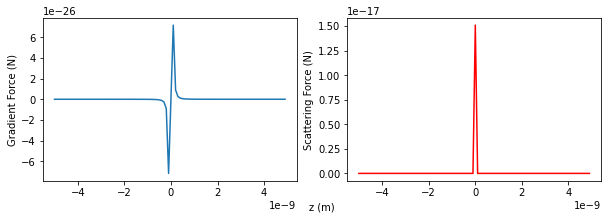

In [26]:
explore_z(1*10**-6, 1.42, 1.47) 

#### Force dependence on $z$ ($1\,\mu m$ PS in DMSO)

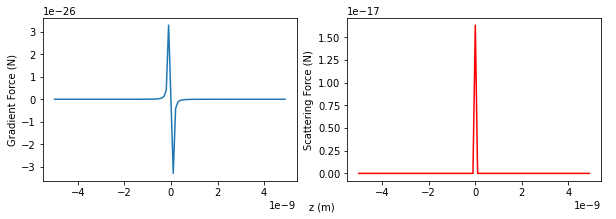

In [27]:
explore_z(1*10**-6, 1.59, 1.47) 

#### Force dependence on $a$ (PS in DMSO) 

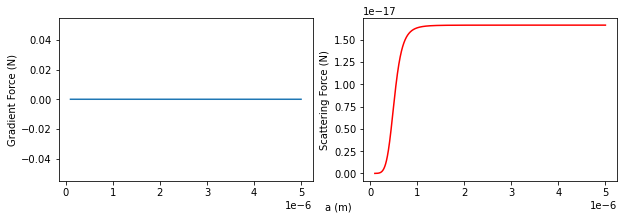

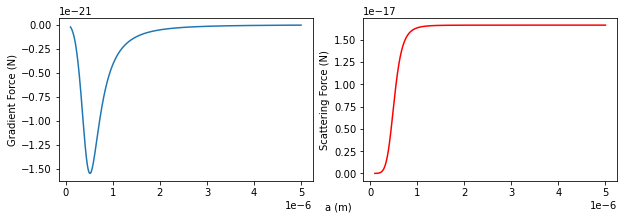

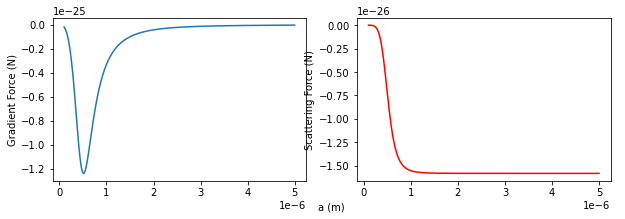

In [28]:
explore_a(0, 1.59, 1.47)
explore_a(1*10**-15, 1.59, 1.47)
explore_a(1*10**-10, 1.59, 1.47)

#### Force dependence on ($\Delta n = n_p - n_m$)

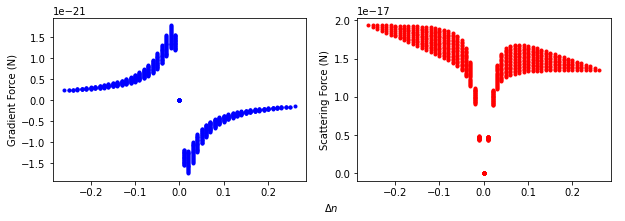

In [29]:
explore_n(1.0*10**-6, 1*10**-15)

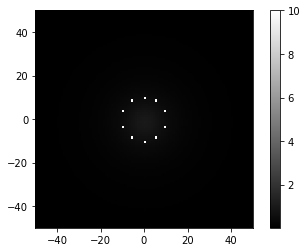

In [3]:
ring_corral()

In [35]:
axial_force_landscape(1*10**-6, 1*10**-15, 1.59, 1.47)

[(60.0, 50.0), (58.09016994374947, 55.877852522924734), (53.09016994374947, 59.510565162951536), (46.90983005625053, 59.510565162951536), (41.90983005625053, 55.877852522924734), (40.0, 50.0), (41.90983005625053, 44.12214747707527), (46.90983005625053, 40.489434837048464), (53.09016994374947, 40.489434837048464), (58.09016994374947, 44.122147477075266), (60.0, 50.0)]
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.